In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
from scipy.stats import multivariate_normal
from scipy.stats import norm
import math
import os

%matplotlib inline


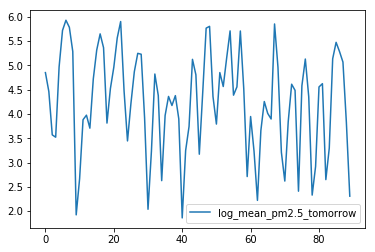

In [7]:
train_df = pd.read_csv("data/Train_log_mean_tomoz_norm.csv")
test_df = pd.read_csv("data/Test_log_mean_tomoz_norm.csv")
#print(train_df.head())
target='log_mean_pm2.5_tomorrow'
toplot = test_df.loc[:,['Date', target]]
toplot.plot()
#toplot[target].hist()

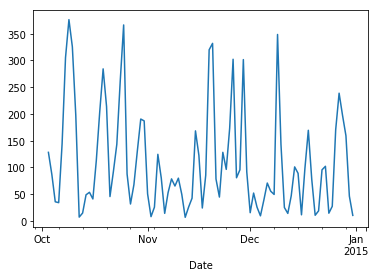

In [8]:
series = pd.read_csv("data/Last_90_days.csv", header=0, index_col=0, parse_dates=True, squeeze=True)
series.plot()
#series

In [9]:
features = ['Iws_min', 'Iws_max', 'Iws_mean', 'DEWP_min', 'DEWP_max',
       'DEWP_mean', 'TEMP_min', 'TEMP_max', 'TEMP_mean', 'PRES_min',
       'PRES_max', 'PRES_mean', 'pm2.5_min', 'pm2.5_max', 'pm2.5_mean']
input_length = len(features)
train_size = len(train_df)

X = train_df.loc[:,features].values
y = train_df.loc[:,[target]].values

X_test = test_df.loc[:,features].values
y_test = test_df.loc[:,[target]].values
test_dates = test_df.loc[:,['Date']].values

# PUT THESE INTO A 
traindata = np.append(X, y, axis=1)
testdata = np.append(X_test, y_test, axis=1)

print(X[0])
print(y[0])

print(traindata[0])


[0.04915228 0.14376588 0.09780791 0.38111888 0.36531987 0.42461353
 0.30237154 0.16552316 0.22471191 0.58348794 0.62727273 0.61037866
 0.2799866  0.20723412 0.28202467]
[4.36733592]
[0.04915228 0.14376588 0.09780791 0.38111888 0.36531987 0.42461353
 0.30237154 0.16552316 0.22471191 0.58348794 0.62727273 0.61037866
 0.2799866  0.20723412 0.28202467 4.36733592]


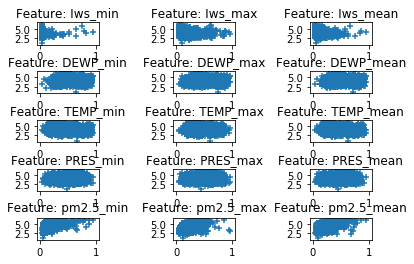

In [95]:
fig = plt.figure()
fig.subplots_adjust(hspace=1.2, wspace=1.2)
for i in range(1, 16):
    plt.subplot(5, 3, i)
    plt.scatter(X[:,i-1], y, marker='+', label=features[i-1])
    plt.title('Feature: ' + features[i-1])


In [17]:
class Network:
        def __init__(self, Topo, Train, Test, learn_rate):
                self.Top = Topo  # NN topology [input, hidden, output]
                self.TrainData = Train
                self.TestData = Test
                np.random.seed()
                self.lrate = learn_rate

                self.W1 = np.random.randn(self.Top[0], self.Top[1]) / np.sqrt(self.Top[0])
                self.B1 = np.random.randn(1, self.Top[1]) / np.sqrt(self.Top[1])  # bias first layer
                self.W2 = np.random.randn(self.Top[1], self.Top[2]) / np.sqrt(self.Top[1])
                self.B2 = np.random.randn(1, self.Top[2]) / np.sqrt(self.Top[1])  # bias second layer

                self.hidout = np.zeros((1, self.Top[1]))  # output of first hidden layer
                self.out = np.zeros((1, self.Top[2]))  # output last layer

        def sigmoid(self, x):
                return 1 / (1 + np.exp(-x))

        def sampleEr(self, actualout):
                error = np.subtract(self.out, actualout)
                sqerror = np.sum(np.square(error)) / self.Top[2]
                return sqerror   

        def ForwardPass(self, X):
                z1 = X.dot(self.W1) - self.B1
                self.hidout = self.sigmoid(z1)  # output of first hidden layer
                z2 = self.hidout.dot(self.W2) - self.B2
                self.out = self.sigmoid(z2)  # output second hidden layer

        def BackwardPass(self, Input, desired):
                out_delta = (desired - self.out) * (self.out * (1 - self.out))
                hid_delta = out_delta.dot(self.W2.T) * (self.hidout * (1 - self.hidout))

                layer = 1  # hidden to output
                for x in range(0, self.Top[layer]):
                        for y in range(0, self.Top[layer + 1]):
                                self.W2[x, y] += self.lrate * out_delta[y] * self.hidout[x]
                for y in range(0, self.Top[layer + 1]):
                        self.B2[y] += -1 * self.lrate * out_delta[y]

                layer = 0  # Input to Hidden
                for x in range(0, self.Top[layer]):
                        for y in range(0, self.Top[layer + 1]):
                                self.W1[x, y] += self.lrate * hid_delta[y] * Input[x]
                for y in range(0, self.Top[layer + 1]):
                        self.B1[y] += -1 * self.lrate * hid_delta[y]

        def decode(self, w):
                w_layer1size = self.Top[0] * self.Top[1]
                w_layer2size = self.Top[1] * self.Top[2]

                w_layer1 = w[0:w_layer1size]
                self.W1 = np.reshape(w_layer1, (self.Top[0], self.Top[1]))

                w_layer2 = w[w_layer1size:w_layer1size + w_layer2size]
                self.W2 = np.reshape(w_layer2, (self.Top[1], self.Top[2]))
                self.B1 = w[w_layer1size + w_layer2size:w_layer1size + w_layer2size + self.Top[1]]
                self.B2 = w[w_layer1size + w_layer2size + self.Top[1]:w_layer1size + w_layer2size + self.Top[1] + self.Top[2]]


        def encode(self):
                w1 = self.W1.ravel()
                w2 = self.W2.ravel()
                w = np.concatenate([w1, w2, self.B1, self.B2])
                return w

        def langevin_gradient(self, data, w, depth):  # BP with SGD (Stocastic BP)

                self.decode(w)  # method to decode w into W1, W2, B1, B2.
                size = data.shape[0]

                Input = np.zeros((1, self.Top[0]))  # temp hold input
                Desired = np.zeros((1, self.Top[2]))
                fx = np.zeros(size)

                for i in range(0, depth):
                        for i in range(0, size):
                                pat = i
                                Input = data[pat, 0:self.Top[0]]
                                Desired = data[pat, self.Top[0]:]
                                self.ForwardPass(Input)
                                self.BackwardPass(Input, Desired)

                w_updated = self.encode()

                return  w_updated

        def evaluate_proposal(self, data, w ):  # BP with SGD (Stocastic BP)

                self.decode(w)  # method to decode w into W1, W2, B1, B2.
                size = data.shape[0]

                Input = np.zeros((1, self.Top[0]))  # temp hold input
                Desired = np.zeros((1, self.Top[2]))
                fx = np.zeros(size)

                for i in range(0, size):  # to see what fx is produced by your current weight update
                        Input = data[i, 0:self.Top[0]]
                        self.ForwardPass(Input)
                        fx[i] = self.out

                return fx

# --------------------------------------------------------------------------

In [18]:

class MCMC:
        def __init__(self,  use_langevin_gradients , l_prob,  learn_rate,  samples, traindata, testdata, topology):
                self.samples = samples  # NN topology [input, hidden, output]
                self.topology = topology  # max epocs
                self.traindata = traindata  #
                self.testdata = testdata
                self.use_langevin_gradients  =  use_langevin_gradients

                self.l_prob = l_prob # likelihood prob

                self.learn_rate =  learn_rate
                # ----------------

        def rmse(self, predictions, targets):
                return np.sqrt(((predictions - targets) ** 2).mean())

        def likelihood_func(self, neuralnet, data, w, tausq):
                y = data[:, self.topology[0]]
                fx = neuralnet.evaluate_proposal(data, w)
                rmse = self.rmse(fx, y)
                loss = -0.5 * np.log(2 * math.pi * tausq) - 0.5 * np.square(y - fx) / tausq
                return [np.sum(loss), fx, rmse]

        def prior_likelihood(self, sigma_squared, nu_1, nu_2, w, tausq):
                h = self.topology[1]  # number hidden neurons
                d = self.topology[0]  # number input neurons
                part1 = -1 * ((d * h + h + 2) / 2) * np.log(sigma_squared)
                part2 = 1 / (2 * sigma_squared) * (sum(np.square(w)))
                log_loss = part1 - part2  - (1 + nu_1) * np.log(tausq) - (nu_2 / tausq)
                return log_loss

        def sampler(self, w_limit, tau_limit):

                # ------------------- initialize MCMC
                testsize = self.testdata.shape[0]
                trainsize = self.traindata.shape[0]
                samples = self.samples

                self.sgd_depth = 1

                x_test = np.linspace(0, 1, num=testsize)
                x_train = np.linspace(0, 1, num=trainsize)

                netw = self.topology  # [input, hidden, output]
                y_test = self.testdata[:, netw[0]]
                y_train = self.traindata[:, netw[0]]
                print (y_train.size)
                print (y_test.size)

                w_size = (netw[0] * netw[1]) + (netw[1] * netw[2]) + netw[1] + netw[2]  # num of weights and bias

                pos_w = np.ones((samples, w_size))  # posterior of all weights and bias over all samples
                pos_tau = np.ones((samples, 1))

                fxtrain_samples = np.ones((samples, trainsize))  # fx of train data over all samples
                fxtest_samples = np.ones((samples, testsize))  # fx of test data over all samples
                rmse_train = np.zeros(samples)
                rmse_test = np.zeros(samples)

                w = np.random.randn(w_size)
                w_proposal = np.random.randn(w_size)

                step_w = w_limit  # defines how much variation you need in changes to w
                step_eta = tau_limit #exp 1

                neuralnet = Network(self.topology, self.traindata, self.testdata, self.learn_rate)
                print ('evaluate Initial w')

                pred_train = neuralnet.evaluate_proposal(self.traindata, w)
                pred_test = neuralnet.evaluate_proposal(self.testdata, w)

                eta = np.log(np.var(pred_train - y_train))
                tau_pro = np.exp(eta)

                sigma_squared = 25
                nu_1 = 0
                nu_2 = 0

                sigma_diagmat = np.zeros((w_size, w_size))  # for Equation 9 in Ref [Chandra_ICONIP2017]
                np.fill_diagonal(sigma_diagmat, step_w)

                delta_likelihood = 0.5 # an arbitrary position

                prior_current = self.prior_likelihood(sigma_squared, nu_1, nu_2, w, tau_pro)  # takes care of the gradients

                [likelihood, pred_train, rmsetrain] = self.likelihood_func(neuralnet, self.traindata, w, tau_pro)
                [likelihood_ignore, pred_test, rmsetest] = self.likelihood_func(neuralnet, self.testdata, w, tau_pro)

                print (likelihood)

                naccept = 0

                langevin_count = 0

                for i in range(samples - 1):

                        lx = np.random.uniform(0,1,1)

                        if (self.use_langevin_gradients is True) and (lx< self.l_prob):
                                w_gd = neuralnet.langevin_gradient(self.traindata, w.copy(), self.sgd_depth) # Eq 8
                                w_proposal = np.random.normal(w_gd, step_w, w_size) # Eq 7
                                w_prop_gd = neuralnet.langevin_gradient(self.traindata, w_proposal.copy(), self.sgd_depth)

                                wc_delta = (w- w_prop_gd)
                                wp_delta = (w_proposal - w_gd )

                                sigma_sq = step_w

                                first = -0.5 * np.sum(wc_delta  *  wc_delta  ) / sigma_sq  # this is wc_delta.T  *  wc_delta /sigma_sq
                                second = -0.5 * np.sum(wp_delta * wp_delta ) / sigma_sq

                                diff_prop =  first - second
                                langevin_count = langevin_count + 1

                        else:
                                diff_prop = 0
                                w_proposal = np.random.normal(w, step_w, w_size)


                        eta_pro = eta + np.random.normal(0, step_eta, 1)
                        tau_pro = math.exp(eta_pro)

                        [likelihood_proposal, pred_train, rmsetrain] = self.likelihood_func(neuralnet, self.traindata, w_proposal, tau_pro)
                        [likelihood_ignore, pred_test, rmsetest] = self.likelihood_func(neuralnet, self.testdata, w_proposal, tau_pro)
                        
                        prior_prop = self.prior_likelihood(sigma_squared, nu_1, nu_2, w_proposal,tau_pro)  # takes care of the gradients

                        diff_prior = prior_prop - prior_current

                        diff_likelihood = likelihood_proposal - likelihood

                        #mh_prob = min(1, math.exp(diff_likelihood + diff_prior + diff_prop))
                        try:
                                mh_prob = min(1, math.exp(diff_likelihood+diff_prior+ diff_prop))

                        except OverflowError as e:
                                mh_prob = 1

                        u = random.uniform(0, 1)
                        if u < mh_prob:
                                print ( i, ' is accepted sample')
                                naccept += 1
                                likelihood = likelihood_proposal
                                prior_current = prior_prop
                                w = w_proposal
                                eta = eta_pro

                                print  (likelihood, prior_current, diff_prop, rmsetrain, rmsetest, w, 'accepted')

                                pos_w[i + 1,] = w_proposal
                                pos_tau[i + 1,] = tau_pro
                                fxtrain_samples[i + 1,] = pred_train
                                fxtest_samples[i + 1,] = pred_test
                                rmse_train[i + 1,] = rmsetrain
                                rmse_test[i + 1,] = rmsetest

                                plt.plot(x_train, pred_train)


                        else:
                                pos_w[i + 1,] = pos_w[i,]
                                pos_tau[i + 1,] = pos_tau[i,]
                                fxtrain_samples[i + 1,] = fxtrain_samples[i,]
                                fxtest_samples[i + 1,] = fxtest_samples[i,]
                                rmse_train[i + 1,] = rmse_train[i,]
                                rmse_test[i + 1,] = rmse_test[i,]

                print (naccept, ' num accepted')
                print (naccept / (samples * 1.0), '% was accepted')
                accept_ratio = naccept / (samples * 1.0) * 100

                print (langevin_count, ' langevin_count')

                return (pos_w, pos_tau, fxtrain_samples, fxtest_samples, x_train, x_test, rmse_train, rmse_test, accept_ratio)

                        

1680
90
evaluate Initial w
-18864.391553478614
0  is accepted sample
-15400.467240650676 -263.6939452771176 -115.64890936395787 3.3868448395310686 3.4132934937116173 [-0.5317939   0.46780177  0.28552307 -1.44578071 -2.23565765  0.21328469
  0.61590084 -0.48165323  0.74366516  1.24299693  1.38474712 -1.32006197
  1.34585707 -0.19890723  0.8911492   0.05431034  0.08413959  0.3170878
 -1.24970218 -1.10309113  0.01289441  0.56003875 -0.25688526 -0.56317171
  0.42824926  0.30407742 -0.62406899  0.67899255 -1.47592926 -0.31239122
  0.85084997  0.79674916  0.97938098  1.54472446 -0.52847144 -0.62188149
 -0.9968341  -1.77498201 -0.7790971   0.31776279  0.16194758  1.24494369
  1.72596386 -0.7028377   0.39661971  0.52757003 -1.44546476  0.53733495
 -0.47329859 -0.49208302 -0.58891873 -0.36609855  0.26393102  1.48133938
  0.40683967  1.22233283  1.35680946 -1.28580268  0.36068349  0.77332755
 -0.6421171  -0.21541755 -0.33912615 -0.89103951 -2.87718296 -1.82088044
  1.21585187  0.65815422  0.3982

6  is accepted sample
-5767.697986030401 -265.20668935083995 -5.07840452383943 3.385635545059462 3.4124583844559284 [-5.34742454e-01  4.35058160e-01  3.17104349e-01 -1.47479198e+00
 -2.22824822e+00  1.51957971e-01  6.63378669e-01 -4.51787029e-01
  7.73986354e-01  1.21516923e+00  1.37569140e+00 -1.28729114e+00
  1.34425505e+00 -2.09883673e-01  7.94179100e-01  8.93858286e-02
  8.62632041e-02  3.34171948e-01 -1.21992614e+00 -1.17016714e+00
  8.04775653e-02  6.30222045e-01 -2.77338462e-01 -5.73001374e-01
  3.58293469e-01  2.70663716e-01 -7.42565088e-01  6.79932380e-01
 -1.47861914e+00 -2.72351437e-01  8.72186991e-01  7.31154580e-01
  1.02162220e+00  1.55150415e+00 -5.36177949e-01 -5.99094049e-01
 -1.07083423e+00 -1.76672344e+00 -8.10336961e-01  3.45491545e-01
  1.75012770e-01  1.24509837e+00  1.83529748e+00 -7.66885372e-01
  4.12135815e-01  5.75786489e-01 -1.45695707e+00  5.45650491e-01
 -5.05184660e-01 -4.61270511e-01 -6.04308063e-01 -3.06255743e-01
  2.96649008e-01  1.43810651e+00  5.166

23  is accepted sample
-4932.172148425185 -265.68300601651845 0 3.385586844459012 3.4124749922158157 [-0.53897144  0.43229409  0.30761764 -1.49870337 -2.25185966  0.1870616
  0.6989745  -0.46156222  0.88785149  1.16270222  1.36693076 -1.29769401
  1.35589841 -0.17846377  0.7177818   0.08338594  0.11756776  0.3624192
 -1.21324464 -1.13646784  0.06521165  0.69657597 -0.32106721 -0.6073568
  0.39952911  0.2710245  -0.74937912  0.70995358 -1.49463858 -0.2680664
  0.98184078  0.73947611  1.02389446  1.51786682 -0.52130724 -0.54541103
 -1.02570987 -1.75177093 -0.75905275  0.43989203  0.2283476   1.34409717
  1.84649962 -0.83364708  0.41728958  0.55955095 -1.43716342  0.51736732
 -0.55923042 -0.52157306 -0.53115948 -0.36478563  0.36831725  1.49277949
  0.49963248  1.29398068  1.35107204 -1.33917356  0.41517519  0.87727519
 -0.71065247 -0.24590291 -0.24404767 -0.86952836 -2.77939242 -1.84809868
  1.25545825  0.55586785  0.35919692  0.28998109  0.04416158  0.24937545
  0.18337007 -0.22271754 -1

37  is accepted sample
-4456.993376910787 -266.3848905509818 0 3.384987155717531 3.4120843847018056 [-0.52974101  0.54377876  0.37385184 -1.41069651 -2.16390399  0.20868912
  0.73669387 -0.43371666  0.80716137  1.06813006  1.41413723 -1.41601746
  1.34866955 -0.07225481  0.72799411  0.14921046  0.19137178  0.42969165
 -1.24971328 -1.17647229  0.05425529  0.65114831 -0.3441641  -0.68175995
  0.3266586   0.1961632  -0.77138069  0.82301501 -1.57841654 -0.32209439
  0.97993342  0.67817125  1.07182918  1.55420775 -0.56323333 -0.45373102
 -0.98206553 -1.7731379  -0.73142007  0.42367824  0.2830773   1.34833187
  1.91431601 -0.80083929  0.39263863  0.55688096 -1.52907505  0.41119915
 -0.49383817 -0.52878013 -0.48882882 -0.50716329  0.427358    1.41172302
  0.52844217  1.2594831   1.39570505 -1.36448821  0.35163421  0.89690374
 -0.596469   -0.21359551 -0.30427445 -0.83238177 -2.71769081 -1.80236379
  1.22692833  0.56185077  0.25386175  0.27403269  0.06116846  0.27865059
  0.25880829 -0.1113501 

48  is accepted sample
-4432.481120915503 -266.66445782929594 -0.44266307919845227 3.3846978033682102 3.4118735327480874 [-0.55492844  0.59325304  0.3662269  -1.36473106 -2.15471473  0.17208134
  0.74566931 -0.33161844  0.81384686  1.05812103  1.37694616 -1.46273162
  1.2604557  -0.01679564  0.74003378  0.13989899  0.25831115  0.45334547
 -1.29428918 -1.26288761  0.03932686  0.66668086 -0.31054717 -0.70534791
  0.35353822  0.15012111 -0.80089316  0.86126908 -1.54895456 -0.3360658
  0.97864927  0.64909369  1.04898391  1.55722459 -0.55362419 -0.43148536
 -0.92662475 -1.77355601 -0.91515494  0.34486306  0.25982263  1.34382092
  1.91651271 -0.87989681  0.40640463  0.44529778 -1.58692499  0.35487545
 -0.48224057 -0.51939324 -0.47181679 -0.42770109  0.3851604   1.3772497
  0.43241707  1.26401721  1.46855454 -1.31733206  0.33801544  0.90122099
 -0.54463344 -0.17317663 -0.287823   -0.88686733 -2.7718408  -1.80649295
  1.33536036  0.5983302   0.31491716  0.33461901  0.10196554  0.30888443
  0.1

74  is accepted sample
-4432.185945854475 -266.7150281022163 -0.40315857127548105 3.384582361444848 3.411799817228958 [-0.5700757   0.65912919  0.38011495 -1.2842826  -2.21175148  0.18535178
  0.79703492 -0.33399284  0.91354399  1.05151345  1.35663168 -1.46411961
  1.29459335 -0.13715841  0.72337301  0.19456302  0.18447822  0.43633538
 -1.32703401 -1.2245513   0.0249289   0.68740008 -0.37614972 -0.67773286
  0.31352066  0.12230135 -0.79807251  0.70895594 -1.61117506 -0.22016758
  0.9699765   0.66538737  1.03071176  1.56878499 -0.50814288 -0.40623187
 -0.92181496 -1.77060813 -0.93153101  0.26334766  0.37775791  1.32022482
  1.95053916 -1.00670777  0.34292991  0.37888788 -1.62052524  0.33646307
 -0.50947371 -0.4311796  -0.4911452  -0.38966871  0.42009336  1.40996731
  0.47591608  1.25916102  1.42199127 -1.30140782  0.27863528  0.91079478
 -0.59559183 -0.15870985 -0.17341737 -0.92837635 -2.76462241 -1.80306908
  1.35169208  0.56150933  0.30528964  0.40890212  0.16027718  0.29971226
  0.17

105  is accepted sample
-4432.156926020005 -266.77456052069437 0 3.3844145189235055 3.4116743953342112 [-5.43098095e-01  5.96221493e-01  3.80908105e-01 -1.28388663e+00
 -2.24390939e+00  2.38777965e-01  7.63997381e-01 -3.33239608e-01
  9.61621874e-01  1.03397776e+00  1.31368657e+00 -1.43936138e+00
  1.33495405e+00 -1.60481167e-01  6.60061559e-01  3.12779131e-01
  1.64703461e-01  4.24219557e-01 -1.38770826e+00 -1.21031555e+00
 -1.43294661e-02  6.79254728e-01 -3.73894370e-01 -6.68122867e-01
  3.02314614e-01  5.56106938e-02 -7.75765120e-01  7.04853884e-01
 -1.61726901e+00 -1.87110676e-01  9.80401573e-01  5.86431377e-01
  1.02207121e+00  1.51513459e+00 -4.92390190e-01 -3.32534854e-01
 -8.99023717e-01 -1.72410193e+00 -8.65153800e-01  2.59318426e-01
  4.57587979e-01  1.35798040e+00  1.94986755e+00 -1.06567188e+00
  4.16547159e-01  4.18185772e-01 -1.65909369e+00  2.91462244e-01
 -5.29591462e-01 -5.01258423e-01 -4.49658813e-01 -4.42435221e-01
  4.60166851e-01  1.43141248e+00  5.27651774e-01  1.

131  is accepted sample
-4432.161921566947 -266.71488616309693 0 3.384396383001583 3.4116634812843722 [-0.55060318  0.67020202  0.32429326 -1.26858557 -2.25989669  0.18371337
  0.74559667 -0.28016772  0.8946512   1.09021004  1.28406528 -1.36081726
  1.3347177  -0.18054865  0.63106153  0.30734399  0.14986796  0.40109962
 -1.28824921 -1.20733464 -0.00807831  0.76515994 -0.35972081 -0.59335208
  0.47192282  0.06431405 -0.77970021  0.71301162 -1.59248605 -0.1791207
  1.04476893  0.72061842  1.01432624  1.49077777 -0.51627846 -0.3520345
 -0.82782087 -1.76331971 -0.75726267  0.26777845  0.47292068  1.37556326
  1.90482722 -0.99900206  0.36703402  0.38000372 -1.68587232  0.32304631
 -0.54474335 -0.45998456 -0.46103393 -0.46418416  0.46013068  1.45444292
  0.4616673   1.26112893  1.49914529 -1.28450728  0.32220937  0.9830198
 -0.5833369  -0.18695123 -0.15941557 -0.76574965 -2.74405043 -1.7328974
  1.32537018  0.59661204  0.3368342   0.3752583   0.1945248   0.27511511
  0.08514891 -0.33771803 -

159  is accepted sample
-4432.0371669913075 -266.7293987808298 0 3.384349695144047 3.411630251529949 [-0.60282835  0.6432109   0.3881761  -1.27176415 -2.32165518  0.19657112
  0.74104873 -0.25905538  0.86125301  1.10514657  1.25373138 -1.41911931
  1.39837843 -0.2265836   0.59305206  0.26941415  0.10212615  0.49127998
 -1.29470817 -1.23919527 -0.01341068  0.74621872 -0.3785467  -0.59847972
  0.44081893  0.0849776  -0.82819274  0.71596508 -1.60939306 -0.21315629
  1.04680481  0.69857613  1.03758415  1.44811087 -0.4387243  -0.34011278
 -0.78340228 -1.72592438 -0.69033655  0.25387713  0.37642511  1.40800341
  1.90066758 -1.01325516  0.45272749  0.33301429 -1.72638625  0.28297249
 -0.53772469 -0.43295058 -0.45039776 -0.48265845  0.45418248  1.4429842
  0.44353172  1.29048895  1.54388742 -1.30886442  0.31016853  1.05914515
 -0.52541652 -0.15636396 -0.14238776 -0.69612492 -2.71166031 -1.68625639
  1.36909371  0.56683798  0.23069931  0.34495294  0.16601704  0.34331368
  0.03626083 -0.36524347

173  is accepted sample
-4432.515400604525 -266.8582468380734 -0.020976336390113204 3.3843148182115295 3.411600912075495 [-0.64953194  0.62117702  0.39982112 -1.22271816 -2.39294378  0.18966127
  0.69587275 -0.20445372  0.82534805  1.12818544  1.22295064 -1.43050234
  1.37523052 -0.2259364   0.62056487  0.30028508  0.17033248  0.46219993
 -1.2979225  -1.25790948  0.03293021  0.72699379 -0.32041567 -0.63155438
  0.52883323  0.05886972 -0.84912141  0.65229721 -1.5051783  -0.2126228
  1.05288865  0.74691079  1.00350619  1.39688423 -0.47107475 -0.3370044
 -0.84724668 -1.76292147 -0.74360685  0.23173459  0.39474421  1.39816656
  1.97112364 -1.01458293  0.45857788  0.30718234 -1.75745425  0.21194518
 -0.62065927 -0.50840627 -0.43066218 -0.53285603  0.4599658   1.43359679
  0.31005243  1.25217586  1.5853267  -1.30490394  0.29346011  1.04484932
 -0.50770651 -0.13071847 -0.13852842 -0.71796932 -2.7910666  -1.62385431
  1.3360819   0.62266627  0.32542379  0.35924998  0.14074331  0.3732835
 -0.02

188  is accepted sample
-4432.206945199346 -266.86055206862983 0 3.3843047775053363 3.4115937091203743 [-6.36106487e-01  5.82525602e-01  5.36546561e-01 -1.24806405e+00
 -2.52720607e+00  1.33877815e-01  7.06170742e-01 -1.70149296e-01
  8.06360719e-01  1.11342445e+00  1.32520474e+00 -1.40221730e+00
  1.34703154e+00 -1.45750247e-01  5.70696594e-01  2.33747893e-01
  1.41537222e-01  4.36033454e-01 -1.30617520e+00 -1.23422115e+00
  4.34644334e-02  7.35380482e-01 -3.59609271e-01 -5.78176463e-01
  5.19998674e-01  4.73528524e-02 -9.48545242e-01  6.00416811e-01
 -1.59754034e+00 -2.62982460e-01  1.08886574e+00  7.47211142e-01
  1.00958747e+00  1.42659471e+00 -4.13896172e-01 -3.04794128e-01
 -8.36548441e-01 -1.76747351e+00 -7.73667097e-01  2.98618297e-01
  3.32429433e-01  1.40655811e+00  1.98393385e+00 -9.94240615e-01
  4.14854244e-01  3.39818000e-01 -1.79709309e+00  2.49393072e-01
 -5.64597474e-01 -5.51956632e-01 -4.01807030e-01 -6.22702738e-01
  5.07082980e-01  1.36086130e+00  3.42246289e-01  1.

225  is accepted sample
-4437.805615746151 -266.93939436745535 0.0222195245566148 3.3843143279574917 3.411597620653427 [-0.65887928  0.62016016  0.55667484 -1.20122285 -2.46754726  0.10167327
  0.7483335  -0.19038454  0.75239134  1.10720321  1.37955073 -1.37263705
  1.30576264 -0.14411971  0.5753851   0.19736888  0.15584433  0.42022876
 -1.28783013 -1.25230351  0.06963968  0.73279954 -0.35268933 -0.63600258
  0.5114284   0.04716332 -0.95083114  0.55604031 -1.58473681 -0.19671284
  1.02631093  0.79073268  1.05687228  1.41902131 -0.3820389  -0.29609343
 -0.84399752 -1.70457697 -0.72062907  0.33229668  0.33334563  1.43407077
  2.04641756 -0.9942096   0.33293352  0.33082412 -1.85679041  0.23236363
 -0.53787076 -0.6087491  -0.42897104 -0.58340226  0.47816617  1.32977367
  0.34051445  1.24072122  1.43457084 -1.23315165  0.30104568  1.12193894
 -0.48655662 -0.22242827 -0.10100922 -0.7007385  -2.82226754 -1.54687925
  1.22705437  0.72781833  0.28122652  0.42242779  0.14524976  0.47311886
  0.0

248  is accepted sample
-4434.8906787616 -266.88046488955246 0 3.3843325683015233 3.411614165454449 [-0.66729342  0.63621343  0.56981514 -1.15129714 -2.46255085  0.15382331
  0.75502029 -0.2519941   0.81873062  1.13407543  1.37102133 -1.41798063
  1.34489407 -0.1594489   0.58774412  0.20692652  0.15283885  0.42886927
 -1.36905122 -1.20047816  0.10073907  0.74026886 -0.35398931 -0.60712437
  0.48155772  0.13048845 -1.05576985  0.59794053 -1.59330933 -0.26700896
  1.01531955  0.71500125  1.01898359  1.40938675 -0.47797489 -0.24493338
 -0.83675137 -1.64620632 -0.70079724  0.37431097  0.41067462  1.43982775
  2.0043666  -1.04090933  0.2887212   0.41761625 -1.88167712  0.12036635
 -0.56987806 -0.65808442 -0.49690996 -0.60402377  0.39197447  1.25043204
  0.31403774  1.26135706  1.36969702 -1.24245458  0.30996514  1.04335337
 -0.41661465 -0.15535373 -0.21966854 -0.67161397 -2.83011892 -1.55016091
  1.25269382  0.72926785  0.26764616  0.27812122  0.11003641  0.49473243
 -0.00923175 -0.18468107

271  is accepted sample
-4432.004466039992 -266.8176878739632 0 3.384318644708438 3.4116012130725055 [-0.69114274  0.66409018  0.67073179 -1.11830813 -2.4492272   0.26129957
  0.81499302 -0.25777295  0.86926412  1.18604782  1.44711805 -1.40441237
  1.33797049 -0.12057411  0.53499918  0.25031656  0.21950688  0.34671184
 -1.38367956 -1.20886615  0.16459737  0.71240626 -0.33943863 -0.57554697
  0.51491552  0.10881213 -1.10108287  0.55284935 -1.59948368 -0.30688146
  0.94082822  0.73723711  0.99641833  1.3476968  -0.47913925 -0.25440106
 -0.86627132 -1.68431842 -0.77483048  0.43323616  0.37430643  1.44527794
  1.92171798 -1.07760888  0.22699278  0.51290156 -1.9363637   0.11781671
 -0.57472311 -0.66437679 -0.46588667 -0.67497981  0.2892558   1.29050768
  0.24421951  1.33401985  1.42316962 -1.23061333  0.40403625  1.01667079
 -0.494439   -0.11869118 -0.14665391 -0.63367539 -2.83692094 -1.60715679
  1.2211801   0.71389861  0.25613516  0.24779833  0.14282982  0.46816487
 -0.03016447 -0.1539989

315  is accepted sample
-4432.18975054709 -266.83322305103206 -0.03599581545228925 3.384294453354123 3.411582715082596 [-0.70656311  0.57389453  0.58550674 -1.02716634 -2.3495177   0.21161113
  0.73202114 -0.27237819  0.84245687  1.18526822  1.42552126 -1.42959275
  1.30359362 -0.12847562  0.59589612  0.27845456  0.17423297  0.35554586
 -1.433079   -1.25687218  0.12348053  0.70004398 -0.37903899 -0.52451814
  0.54116446  0.23021276 -1.06188236  0.56007265 -1.59920946 -0.35393445
  0.99356609  0.75165522  0.94751061  1.25840169 -0.49781266 -0.25689881
 -0.88748307 -1.66404663 -0.71591648  0.47576693  0.4203563   1.43093913
  1.93856151 -1.00075176  0.24227201  0.52218453 -1.84804699  0.05359658
 -0.51584498 -0.65834813 -0.4442037  -0.68792294  0.19654897  1.27649827
  0.26550964  1.33189423  1.39995058 -1.2898674   0.39504531  1.01657276
 -0.50933479 -0.13164026 -0.11081974 -0.63021147 -2.7602138  -1.59834051
  1.30802002  0.71926246  0.23728164  0.32925296  0.10850174  0.51476679
 -0.0

331  is accepted sample
-4432.183971648243 -266.82021961888165 -0.013003568233238116 3.384298979765037 3.4115890362738583 [-7.03821260e-01  5.52159565e-01  5.35188349e-01 -1.00767456e+00
 -2.33370519e+00  2.13657460e-01  6.57354380e-01 -2.67210077e-01
  9.05906681e-01  1.11654976e+00  1.43323631e+00 -1.42781571e+00
  1.29939746e+00 -1.22960747e-01  6.32572765e-01  2.22561104e-01
  1.34681809e-01  3.02032137e-01 -1.45544160e+00 -1.29509478e+00
  1.34952082e-01  7.19837073e-01 -4.26353136e-01 -5.48115670e-01
  5.98538191e-01  2.61057383e-01 -1.10110751e+00  5.42503024e-01
 -1.64145135e+00 -3.90160099e-01  1.01638348e+00  7.73023297e-01
  9.16865186e-01  1.19515151e+00 -5.45187631e-01 -2.30075230e-01
 -9.68163875e-01 -1.64368651e+00 -6.60783316e-01  4.16755788e-01
  3.91624841e-01  1.48991006e+00  1.96782346e+00 -9.67673288e-01
  3.60068055e-01  5.14010187e-01 -1.86254320e+00  1.15132577e-01
 -5.01414183e-01 -6.15796948e-01 -2.71556956e-01 -6.49820675e-01
  2.49174792e-01  1.27715055e+00 

342  is accepted sample
-4432.105870255813 -266.8252334486304 -0.01028192604848921 3.3842958671867276 3.41158739799706 [-6.49025451e-01  5.77671522e-01  5.48736734e-01 -9.74154222e-01
 -2.30277213e+00  2.70477965e-01  6.70099529e-01 -3.17968234e-01
  8.92661755e-01  1.10949515e+00  1.46615886e+00 -1.46585172e+00
  1.22463419e+00 -1.65416018e-01  5.63967632e-01  2.40918430e-01
  8.62548227e-02  2.61654023e-01 -1.38253365e+00 -1.28719636e+00
  1.60663259e-01  6.46756012e-01 -5.47953608e-01 -5.56641344e-01
  6.55486752e-01  3.19030097e-01 -1.05226827e+00  5.53702789e-01
 -1.56093473e+00 -4.11908957e-01  1.01456847e+00  8.45995994e-01
  9.77777605e-01  1.16006457e+00 -5.41527840e-01 -1.82560529e-01
 -9.08652310e-01 -1.65831325e+00 -5.90288068e-01  4.04686387e-01
  4.76235790e-01  1.55919675e+00  1.92475673e+00 -1.02885793e+00
  3.64830642e-01  5.08783411e-01 -1.81020282e+00  7.29085628e-02
 -5.09805671e-01 -5.95806661e-01 -3.36400802e-01 -7.09815316e-01
  2.76218537e-01  1.25036505e+00  3.

361  is accepted sample
-4433.697460718597 -266.9159698324301 0 3.3842783345460803 3.411571895032344 [-0.65183005  0.58553009  0.59594245 -0.97501398 -2.27131746  0.31363113
  0.68710283 -0.3421284   1.03930686  1.13783139  1.45629961 -1.43226829
  1.29210575 -0.12518147  0.63507012  0.24812575  0.03407584  0.2229256
 -1.3495646  -1.32413197  0.209865    0.61295256 -0.52379789 -0.63208007
  0.61192639  0.38890636 -1.07575818  0.50696477 -1.58797602 -0.42110308
  0.98430375  0.80957183  0.98875959  1.13654461 -0.65303525 -0.18737849
 -0.91150005 -1.67377031 -0.63711601  0.38214635  0.50744037  1.54401216
  1.88718881 -1.05275555  0.41230032  0.52570201 -1.77875091  0.01783327
 -0.48638558 -0.5433532  -0.29570899 -0.72164593  0.33374135  1.27174052
  0.33619453  1.34124998  1.543024   -1.39748861  0.31460243  1.17154794
 -0.42119431 -0.19571331  0.05464485 -0.71356609 -2.69113717 -1.51040279
  1.41732996  0.56173821  0.25387044  0.28734434 -0.06328481  0.48792401
 -0.1150454  -0.28096345

377  is accepted sample
-4433.54426326613 -266.9287152536129 0 3.384292816037617 3.411583990811456 [-7.24769649e-01  5.77751606e-01  6.29680112e-01 -9.28079910e-01
 -2.27356436e+00  2.09881858e-01  7.04988229e-01 -3.54758426e-01
  1.07364832e+00  1.07809075e+00  1.54969136e+00 -1.33241108e+00
  1.24943585e+00 -1.85767241e-02  7.00711262e-01  2.85141388e-01
  2.54208000e-02  1.72529951e-01 -1.29907181e+00 -1.29107659e+00
  2.44917577e-01  6.19393882e-01 -4.52243699e-01 -6.62920274e-01
  6.66212900e-01  3.47941662e-01 -1.06236356e+00  4.28538042e-01
 -1.48934010e+00 -5.35476126e-01  9.78446994e-01  8.48036593e-01
  9.67260616e-01  1.15749769e+00 -7.11536946e-01 -1.79026526e-01
 -9.66052521e-01 -1.67589325e+00 -6.30814856e-01  3.13996496e-01
  5.32003474e-01  1.40978859e+00  1.86969758e+00 -9.64044838e-01
  3.92346991e-01  5.59939527e-01 -1.79284934e+00  4.33805276e-02
 -3.83690048e-01 -5.69224728e-01 -2.31155947e-01 -7.69191691e-01
  3.17966292e-01  1.34053575e+00  3.72435289e-01  1.3330

393  is accepted sample
-4432.428078580813 -266.85209596260387 -0.011892923851898551 3.3842797551820145 3.4115738788799006 [-0.63563212  0.56830619  0.60935003 -0.93128031 -2.21741001  0.19316272
  0.71000816 -0.39922804  1.00685632  1.06704251  1.56387052 -1.3327805
  1.28784545 -0.09576549  0.56611815  0.23847792 -0.0321124   0.18884365
 -1.25710137 -1.27784464  0.28801628  0.59060913 -0.39286534 -0.63851986
  0.71198437  0.28471318 -1.12785354  0.4214368  -1.51767845 -0.45881246
  0.95845872  0.85355058  1.06078707  1.15603275 -0.73357544 -0.09542532
 -0.90811894 -1.77416946 -0.73926556  0.29973165  0.62354347  1.5009687
  1.82739105 -0.89943751  0.45786562  0.52716743 -1.84076323  0.02060097
 -0.46760456 -0.45778151 -0.22588075 -0.82248614  0.30954054  1.35843556
  0.36247434  1.26900028  1.50532724 -1.44151707  0.35253373  1.02066906
 -0.41650471 -0.16359032 -0.05259475 -0.69847174 -2.65041559 -1.46495644
  1.50292221  0.59514296  0.25428022  0.1936706  -0.21304877  0.57467443
 -0

405  is accepted sample
-4432.011670717898 -266.89321822986034 -0.01678407930996917 3.384279154030352 3.411572428846734 [-0.61076714  0.60502832  0.56880236 -0.950831   -2.31262063  0.19204452
  0.69760299 -0.3272707   0.94623603  1.08295807  1.60848666 -1.27064925
  1.32695935 -0.03558311  0.55497939  0.21041357 -0.05147325  0.20266984
 -1.15477468 -1.28505724  0.3251256   0.53244156 -0.4588169  -0.56258995
  0.67995013  0.22879617 -1.13170283  0.37861527 -1.48617656 -0.46076387
  0.93218919  0.86931288  0.97550782  1.11161919 -0.72742509 -0.18154937
 -0.83515625 -1.78994668 -0.76089771  0.25111385  0.69723967  1.56049082
  1.77654936 -0.9240463   0.45047869  0.55756707 -1.83606177  0.07026392
 -0.47747495 -0.38946483 -0.15506161 -0.75475347  0.34434833  1.38696854
  0.31761406  1.26214823  1.50234561 -1.39335626  0.30852256  0.92854166
 -0.45902256 -0.15010274 -0.06933664 -0.71772474 -2.70457958 -1.45470392
  1.53972631  0.66572974  0.25396238  0.13204986 -0.21057374  0.60256912
 -0.

438  is accepted sample
-4432.407087899539 -266.98292952053833 -0.00014324192618309084 3.3842648208359845 3.411560782300012 [-5.45953918e-01  5.44242789e-01  4.99402478e-01 -9.36313091e-01
 -2.25001103e+00  2.23274434e-01  5.79867310e-01 -2.98008449e-01
  9.72442816e-01  1.05974824e+00  1.65309781e+00 -1.24225856e+00
  1.29426862e+00  2.33119494e-02  5.15238081e-01  2.21915341e-01
 -9.94437226e-02  2.05225731e-01 -1.14159809e+00 -1.19526107e+00
  2.73785431e-01  6.29365575e-01 -4.56495224e-01 -5.29974209e-01
  6.44562035e-01  1.52451667e-01 -1.05519122e+00  3.92842895e-01
 -1.43335530e+00 -4.74959269e-01  1.01628264e+00  9.03853106e-01
  9.55487822e-01  1.16955509e+00 -6.39640305e-01 -1.85776522e-01
 -8.59655691e-01 -1.85405239e+00 -8.02988577e-01  2.37052544e-01
  7.19945405e-01  1.54962147e+00  1.72481043e+00 -9.48523049e-01
  4.20448447e-01  6.61394440e-01 -1.78619519e+00  1.83041328e-02
 -4.86832774e-01 -4.27735102e-01 -2.13227597e-01 -6.71485991e-01
  3.34169477e-01  1.37748784e+0

450  is accepted sample
-4432.121877874002 -266.9634423521513 0 3.384255911010774 3.4115545528228837 [-0.60137113  0.55639498  0.55948743 -0.90331931 -2.22008041  0.25907801
  0.54705934 -0.29438176  1.05343954  1.01703731  1.62162555 -1.23293743
  1.39110671 -0.03209524  0.36414476  0.34769349 -0.0938753   0.13027603
 -1.11995472 -1.27437095  0.32682575  0.6634964  -0.41811109 -0.57049557
  0.68202881  0.16130159 -0.9985607   0.3307547  -1.3912894  -0.52725285
  1.02519463  0.95895859  0.9378244   1.18830109 -0.54063582 -0.23913402
 -0.84252513 -1.92275923 -0.79467772  0.27967592  0.71998101  1.52928824
  1.70641007 -0.92335812  0.46649244  0.77051631 -1.83128818  0.05712204
 -0.55202805 -0.41437306 -0.19511192 -0.70199348  0.36795347  1.30765284
  0.32559611  1.17282379  1.52871408 -1.37528345  0.44720527  1.06213249
 -0.48706437 -0.14532281 -0.06678963 -0.68643793 -2.62197472 -1.60251708
  1.49660489  0.54788143  0.13304827  0.11576542 -0.11075947  0.57141665
 -0.04675543 -0.1512586

487  is accepted sample
-4434.090463763131 -266.93857900703824 -0.0162177218620565 3.384242540165775 3.4115422912919198 [-0.52255884  0.58596646  0.61737103 -0.91633765 -2.15512562  0.25250522
  0.47512775 -0.39116446  0.96748545  1.04483667  1.609423   -1.17849994
  1.38234793 -0.08660792  0.29062255  0.2944735  -0.03566837  0.13514618
 -1.09788952 -1.26378169  0.29772164  0.65600089 -0.34823689 -0.62748074
  0.69418096  0.10387195 -1.06255151  0.24590232 -1.46730575 -0.5192293
  1.03586001  1.01606509  0.98926038  1.05961942 -0.49525742 -0.29280617
 -0.78151082 -1.97177377 -0.74024736  0.26285158  0.74229422  1.49910385
  1.6940842  -0.99354478  0.48498295  0.88046173 -1.85146287  0.04204776
 -0.46984483 -0.3768393  -0.1726519  -0.7094635   0.34137047  1.36006094
  0.28617097  1.14819466  1.4449475  -1.31924093  0.55648196  0.98660838
 -0.44563677 -0.10591119 -0.11825975 -0.7941364  -2.6739987  -1.65586342
  1.41660148  0.66194671  0.02817748  0.06675419 -0.06557783  0.58312028
 -0.0

501  is accepted sample
-4431.998067997767 -267.0528261344063 -0.00952896172896045 3.3842325537187348 3.411533497754445 [-0.49204474  0.57537592  0.69055935 -0.92194227 -2.07496579  0.25220155
  0.40819395 -0.45748869  0.84956072  0.96285793  1.53082813 -1.11802254
  1.42431627 -0.05588889  0.23275519  0.266812   -0.00708389  0.21535973
 -1.18220222 -1.26510221  0.26082841  0.59508807 -0.42872025 -0.66054879
  0.66119497  0.15593224 -1.10238515  0.16236973 -1.46806685 -0.45504442
  1.11832229  1.002621    1.05185735  1.04832901 -0.52090627 -0.22814594
 -0.71914472 -2.02585466 -0.74111647  0.1565882   0.82312714  1.53773104
  1.70206555 -0.99489575  0.50685722  0.85076897 -1.75911222 -0.03178734
 -0.34456782 -0.45139179 -0.15043191 -0.67952649  0.3734889   1.30107644
  0.25188779  1.18931374  1.5405232  -1.31215044  0.60765534  0.96454215
 -0.51069222 -0.13780671 -0.15649886 -0.71738315 -2.7248604  -1.68756759
  1.36892034  0.70956897  0.03722447  0.08619954 -0.02735732  0.52258827
 -0.

513  is accepted sample
-4432.990917779634 -266.93623642837326 -0.010791218918123402 3.3842267199092424 3.4115294794645528 [-0.50640022  0.57615729  0.6253044  -0.91977942 -2.03555548  0.24416796
  0.43630459 -0.52008598  0.81756712  0.95511243  1.51044136 -1.08239989
  1.3747356  -0.03997691  0.28904856  0.37253437  0.01849344  0.24932874
 -1.18941398 -1.27298951  0.24641326  0.58995286 -0.40026422 -0.62496669
  0.62036621  0.12121786 -1.09851827  0.17859596 -1.40042373 -0.52635956
  1.16693707  0.92603362  1.05571746  0.98782771 -0.47437477 -0.16295673
 -0.7536765  -2.07802188 -0.7238332   0.12619784  0.8220746   1.58546765
  1.69491894 -0.99822293  0.45981141  0.83390196 -1.71830012 -0.03075081
 -0.30333461 -0.3615466  -0.11354384 -0.62266225  0.37064191  1.27881532
  0.32836274  1.11570481  1.52265137 -1.23810503  0.57428512  0.92327507
 -0.49141426 -0.14907416 -0.12867719 -0.67065146 -2.58382704 -1.68375049
  1.35778571  0.74041841  0.04021994  0.15726386 -0.01534332  0.56037962
 

523  is accepted sample
-4432.188422147185 -266.9906686725989 0 3.3842225405762156 3.4115256155979674 [-0.45079421  0.6776283   0.59976476 -0.89593868 -2.02561574  0.27484545
  0.44048484 -0.54373424  0.86638539  0.99539601  1.41798056 -1.03540449
  1.42665186 -0.04814856  0.33937802  0.33830214  0.08143294  0.25714542
 -1.1570489  -1.37904528  0.25703481  0.56757382 -0.44621595 -0.64718813
  0.58820886  0.13084325 -1.06495126  0.20110177 -1.40026048 -0.55209994
  1.2619725   0.91051912  1.04807427  1.05814419 -0.48136348 -0.19232694
 -0.7082668  -2.11939514 -0.7256459   0.07420584  0.76924077  1.61665254
  1.72776445 -0.98427591  0.43873386  0.78462814 -1.65572784  0.05807385
 -0.30160787 -0.36829682 -0.11519677 -0.6179885   0.42351486  1.28198783
  0.32936867  1.16001279  1.43716482 -1.21237339  0.64912735  0.9459014
 -0.43920923 -0.24615355 -0.21547673 -0.64379751 -2.57583134 -1.63844826
  1.3697326   0.76022596  0.0135916   0.16212833  0.01824605  0.57827234
 -0.12956619 -0.1758698

552  is accepted sample
-4433.089900959484 -267.04969762240455 0 3.384220940998308 3.4115247771161146 [-4.87474604e-01  6.91015081e-01  5.86812195e-01 -8.69646881e-01
 -2.00184290e+00  2.88740304e-01  4.30216583e-01 -6.15176611e-01
  8.64822442e-01  1.01387758e+00  1.37405079e+00 -1.04395844e+00
  1.39979043e+00 -8.24002236e-02  2.32065390e-01  3.22658517e-01
  1.05517394e-01  2.72998758e-01 -1.18571372e+00 -1.35029980e+00
  3.68121553e-01  5.96813935e-01 -5.26662445e-01 -6.65264230e-01
  5.73311535e-01  1.56923214e-01 -1.08242224e+00  2.78358709e-01
 -1.31364187e+00 -5.46713787e-01  1.32204981e+00  9.86192292e-01
  1.13430884e+00  1.11042338e+00 -4.29023442e-01 -2.41355231e-01
 -7.41365598e-01 -2.09519536e+00 -7.46938579e-01  1.05535802e-01
  7.20372793e-01  1.68379566e+00  1.74792067e+00 -1.09826927e+00
  4.68225614e-01  8.08734253e-01 -1.64492774e+00  1.26096686e-02
 -3.06165767e-01 -3.63407763e-01 -1.40568545e-01 -6.12112862e-01
  4.69139216e-01  1.27994217e+00  2.66184632e-01  1.2

561  is accepted sample
-4432.478124165829 -267.0726043947321 -0.004653963540159234 3.3842165223174847 3.4115215940168744 [-0.42678876  0.70608543  0.48207893 -0.87401701 -1.97058763  0.33562681
  0.39467665 -0.59733191  0.86682287  1.01528964  1.41452628 -1.01578369
  1.48873269 -0.05633353  0.24409595  0.31383757  0.0993541   0.22150348
 -1.1661915  -1.28992474  0.37714831  0.63644214 -0.54663349 -0.62871854
  0.55414011  0.23073219 -1.04697578  0.22670481 -1.24354647 -0.6358332
  1.3333449   0.97743182  1.22495684  0.98388236 -0.49610716 -0.26970477
 -0.72418589 -2.09558656 -0.75595784  0.10345212  0.74241073  1.71420704
  1.76617947 -1.08838679  0.51751999  0.75826021 -1.55492728 -0.02574201
 -0.32504909 -0.29319302 -0.18235901 -0.61244165  0.45316619  1.24706868
  0.27903692  1.26130572  1.43668546 -1.24422006  0.67191339  0.88213478
 -0.45341919 -0.28650743 -0.12477578 -0.68078341 -2.69170165 -1.66727541
  1.44923689  0.78150329 -0.01577823  0.16342331  0.12940363  0.5943221
 -0.

583  is accepted sample
-4432.426118597518 -267.1070111532565 0 3.384223243516444 3.4115264792581286 [-0.39676453  0.6318129   0.55034009 -0.80438284 -2.04163108  0.38131034
  0.37593302 -0.59107947  0.84574096  0.99630702  1.42256526 -0.99139854
  1.50798781 -0.02881436  0.29950488  0.3337223   0.19383773  0.32892667
 -1.15787277 -1.30031644  0.34565286  0.64201746 -0.59540601 -0.69874752
  0.53113531  0.22020629 -1.05722594  0.16033701 -1.15071942 -0.62351091
  1.33786502  1.01234797  1.24140127  0.97401648 -0.52502564 -0.22929375
 -0.72210049 -2.06393632 -0.70733701  0.09996116  0.71482042  1.70338582
  1.77996291 -1.09681313  0.45345376  0.81655837 -1.49138186 -0.02724299
 -0.38088023 -0.33447793 -0.2704756  -0.64756618  0.40165663  1.2402297
  0.28325126  1.2809963   1.499293   -1.17618273  0.56357674  0.97401965
 -0.45433223 -0.26328198 -0.03713947 -0.67143498 -2.76475178 -1.76127701
  1.45356284  0.71991267 -0.01099815  0.16269483  0.12574971  0.64235979
 -0.23856192 -0.16092239

627  is accepted sample
-4431.963495270683 -267.1136501144478 0.0013778301382547653 3.3842232504826377 3.411525152056151 [-4.24369816e-01  6.85463008e-01  5.38316192e-01 -8.16023037e-01
 -1.99152482e+00  3.68004454e-01  3.94650145e-01 -5.79882910e-01
  8.09063451e-01  1.03775260e+00  1.40042789e+00 -9.98417760e-01
  1.48037219e+00 -4.70351895e-03  3.33747915e-01  3.24501699e-01
  2.29884686e-01  2.86346158e-01 -1.18223800e+00 -1.21414181e+00
  3.50210726e-01  5.90808585e-01 -6.28928411e-01 -7.65977397e-01
  5.10484124e-01  2.36648793e-01 -1.02470299e+00  1.74232337e-01
 -1.10676323e+00 -5.71458537e-01  1.32593051e+00  9.32053824e-01
  1.11974825e+00  9.51930104e-01 -5.61478691e-01 -1.95075304e-01
 -6.93660775e-01 -2.04997107e+00 -8.07373006e-01  1.17352408e-01
  8.19102844e-01  1.68529456e+00  1.80476850e+00 -1.04428704e+00
  4.23562182e-01  8.61133732e-01 -1.51500179e+00  6.40436299e-03
 -3.54096045e-01 -3.61064988e-01 -2.18133446e-01 -6.34071951e-01
  4.58361486e-01  1.33022266e+00  

650  is accepted sample
-4432.109212324618 -267.12797568056897 0.0006093755861371619 3.384220161883005 3.4115227854125885 [-4.09978098e-01  6.03842934e-01  5.24024993e-01 -8.08370066e-01
 -1.99110469e+00  3.43754805e-01  4.06726963e-01 -5.33624623e-01
  7.76287133e-01  1.11051859e+00  1.48334994e+00 -9.75957137e-01
  1.50141524e+00 -6.09938026e-02  4.23888339e-01  3.41293304e-01
  2.48752437e-01  2.69987399e-01 -1.20008480e+00 -1.18872010e+00
  3.16586427e-01  4.73646086e-01 -5.31174473e-01 -7.15362873e-01
  5.90821049e-01  1.78668453e-01 -1.02583076e+00  1.85052730e-01
 -1.12604514e+00 -6.30002565e-01  1.28296498e+00  9.19167586e-01
  1.09304362e+00  1.01960482e+00 -6.38123655e-01 -2.67566019e-01
 -6.39657652e-01 -2.10618618e+00 -7.76131251e-01  1.21599251e-01
  7.92704639e-01  1.71066686e+00  1.76489812e+00 -1.08051025e+00
  5.14768678e-01  8.62798578e-01 -1.47955191e+00  1.03187498e-01
 -3.96358180e-01 -3.63274324e-01 -2.77136594e-01 -5.44298538e-01
  5.17715994e-01  1.33966158e+00 

664  is accepted sample
-4432.755891928433 -267.159560355117 0.004495289597181706 3.3842164244666373 3.4115192649568824 [-0.47918304  0.55250487  0.55636228 -0.79881319 -2.01571974  0.34951051
  0.49003975 -0.50797192  0.81490007  1.07308645  1.46971818 -0.92162704
  1.52748073 -0.03999995  0.44714089  0.37770991  0.31239258  0.21145146
 -1.24239711 -1.18086962  0.32370151  0.57381028 -0.41063727 -0.69476013
  0.51042563  0.08885029 -1.12095636  0.18428001 -1.15158468 -0.57902409
  1.26103984  1.02975428  1.08417813  1.01568483 -0.60707685 -0.35516397
 -0.58100183 -2.0602928  -0.72428688  0.01768904  0.81879306  1.58900339
  1.74107322 -1.08952133  0.54356236  0.87133031 -1.50826869  0.12648244
 -0.3392359  -0.40332344 -0.25703235 -0.53360167  0.4615024   1.30282643
  0.31924985  1.39327219  1.46366499 -1.14513309  0.5778669   0.95075435
 -0.45075431 -0.30451982  0.13830443 -0.71440037 -2.9159712  -1.75218232
  1.51739204  0.65173388 -0.07094391  0.18764601  0.29972126  0.50812163
 -0.

680  is accepted sample
-4432.636899995139 -267.16298168629123 0 3.384213509092458 3.4115164318870717 [-0.52287105  0.47454445  0.53430993 -0.86916316 -2.01896463  0.37933064
  0.46596859 -0.52295675  0.76818902  0.98198598  1.38025561 -0.87447667
  1.56125155 -0.06973393  0.43657415  0.34632651  0.27810196  0.09512734
 -1.25775145 -1.0947438   0.26562582  0.61322178 -0.4577063  -0.7297628
  0.61576954  0.16247784 -1.15731817  0.10507827 -1.07561371 -0.54771103
  1.21267095  1.01247319  1.06159496  0.8903142  -0.58510774 -0.40118033
 -0.61164434 -2.12405234 -0.72916643 -0.05076161  0.79613471  1.60676895
  1.65923718 -1.16405585  0.54348986  0.90306062 -1.42572689  0.15473869
 -0.30801763 -0.3557651  -0.32525791 -0.52753715  0.44592721  1.2890765
  0.2366877   1.36191483  1.42272096 -1.1805836   0.55271369  0.96024624
 -0.38029844 -0.33255339  0.06219664 -0.7683205  -2.84810277 -1.70937963
  1.5187449   0.75711464 -0.0766842   0.16193583  0.38325046  0.49890174
 -0.12838133 -0.2876544 

691  is accepted sample
-4431.947910716386 -267.1958258055161 0 3.384214865657923 3.4115168668369984 [-0.43210145  0.45690691  0.49393128 -0.77438965 -1.97507836  0.34100807
  0.49290987 -0.52216528  0.80113156  0.97102941  1.39289862 -0.75714158
  1.49580582 -0.02714981  0.4806171   0.35810056  0.29033379  0.11307886
 -1.21881015 -1.14773955  0.20302045  0.63961327 -0.46537068 -0.72630267
  0.65157947  0.14333922 -1.13788657  0.05420466 -1.1417475  -0.53566788
  1.09441812  1.0056634   1.01694056  0.91142506 -0.65151396 -0.36111832
 -0.61421049 -2.16371898 -0.76248757 -0.02590195  0.7229083   1.59694135
  1.64460794 -1.09713752  0.50255288  0.84324964 -1.44769651  0.10786708
 -0.24678886 -0.32186222 -0.35935204 -0.59474758  0.39186759  1.26283486
  0.29447912  1.35608043  1.39784036 -1.15986199  0.55763955  1.05273675
 -0.31122616 -0.35380095  0.03260282 -0.79918174 -2.84778896 -1.71030753
  1.51886048  0.67521527 -0.12190354  0.15946788  0.30619691  0.41221597
 -0.13819418 -0.2593801

718  is accepted sample
-4431.944144257457 -267.2186972787972 0 3.3842134293331263 3.4115160271493004 [-0.34870785  0.42435166  0.47105896 -0.72734995 -1.97764268  0.35496661
  0.47094349 -0.40139165  0.76052605  0.99283254  1.46792044 -0.78334764
  1.47459964 -0.04451773  0.47669169  0.39331921  0.36650111  0.12548961
 -1.12859485 -1.23714521  0.24255272  0.62364945 -0.45927522 -0.80059804
  0.6672212   0.13316587 -1.12120873 -0.0151928  -1.07913912 -0.51692757
  1.08876001  1.03491292  1.0538466   0.87303757 -0.65517109 -0.42262938
 -0.55517956 -2.19566186 -0.8051616  -0.04576444  0.7108847   1.52013436
  1.6303286  -1.09539274  0.54193531  0.83842952 -1.39032624  0.16321666
 -0.24852376 -0.27388188 -0.32180555 -0.58304914  0.31081466  1.39076009
  0.26231513  1.32550735  1.49340902 -1.10785699  0.42326589  1.05803228
 -0.30361646 -0.39231064 -0.00983715 -0.68101687 -2.91797732 -1.80362621
  1.53437027  0.69382816 -0.05046855  0.13276309  0.25964406  0.47749814
 -0.12014852 -0.160654

727  is accepted sample
-4432.287790050941 -267.1902830145099 0 3.3842167880158742 3.4115177621369486 [-0.44483995  0.44807153  0.45337955 -0.75958468 -2.02109504  0.39198005
  0.46785467 -0.37085754  0.76608279  0.92032317  1.44533433 -0.74065187
  1.58328683 -0.178992    0.51985741  0.33840202  0.34028955  0.14894259
 -1.09740813 -1.20286815  0.33178193  0.64238711 -0.36729303 -0.7788357
  0.60759082  0.16086044 -1.20164168 -0.02485782 -1.02219141 -0.51883979
  1.05645624  1.04956955  0.98104307  0.7868746  -0.7583467  -0.45379139
 -0.53184502 -2.12981807 -0.84604203 -0.11986489  0.72180262  1.46540828
  1.63045372 -1.00552544  0.50516927  0.83995097 -1.44552028  0.24983758
 -0.26674753 -0.28494778 -0.37374442 -0.57514513  0.30497636  1.39604884
  0.23177329  1.27465759  1.45934845 -1.0830009   0.43774709  1.12637054
 -0.36008431 -0.45082356  0.04640332 -0.64888105 -2.90543427 -1.79757001
  1.50890998  0.72826152 -0.05751067  0.18463338  0.27699039  0.50269007
 -0.22436386 -0.1940495

742  is accepted sample
-4433.293342094741 -267.19094439305667 -0.007743799983894295 3.384215015912803 3.4115164872306227 [-0.49670442  0.46815696  0.33704109 -0.76026283 -2.01543726  0.35144662
  0.45312905 -0.39083006  0.7702056   0.8968259   1.40643567 -0.74657824
  1.50860893 -0.17034755  0.58845363  0.36655379  0.40735825  0.18105055
 -1.14318899 -1.26245232  0.3004969   0.78377289 -0.34220367 -0.81397466
  0.55073838  0.21701057 -1.12966256 -0.13424465 -1.00528067 -0.5308322
  1.07546418  1.05125183  0.97532064  0.83959771 -0.73324575 -0.37593565
 -0.57404508 -2.08275026 -0.86107518 -0.09521407  0.75143164  1.51817256
  1.59123497 -0.97056114  0.58124636  0.82639972 -1.42753699  0.19586957
 -0.28622364 -0.33877962 -0.36210807 -0.70183986  0.44126127  1.40004722
  0.10915687  1.31485552  1.37759969 -1.0461139   0.41363855  1.07535608
 -0.37906198 -0.36648362  0.0164798  -0.52618933 -2.92107282 -1.77791426
  1.55128453  0.70241911 -0.10030639  0.22186232  0.29581077  0.53166766
 -0

750  is accepted sample
-4432.014829470563 -267.1446410115375 -0.00172915837954557 3.384213729054817 3.4115154642416847 [-0.49042436  0.43158168  0.3325757  -0.72677254 -2.00150362  0.23243026
  0.478048   -0.42055859  0.68970488  0.88647582  1.38749756 -0.73447781
  1.49489216 -0.18088507  0.60277643  0.40257832  0.44657514  0.23911195
 -1.19189348 -1.25625028  0.31386577  0.7846776  -0.34979496 -0.7709557
  0.51617282  0.2598149  -1.18985961 -0.19493742 -0.96067272 -0.59161287
  1.06833958  0.93104495  0.94401101  0.91787229 -0.74724871 -0.33061142
 -0.68279152 -2.11462136 -0.8501714  -0.10683746  0.70131976  1.5483591
  1.62381862 -0.91654934  0.64578349  0.77253864 -1.39176015  0.13408641
 -0.28355705 -0.33233181 -0.27093158 -0.67848668  0.38837009  1.38503477
  0.12719193  1.24185789  1.3540366  -1.09500833  0.41217422  1.05838936
 -0.41592622 -0.43779394  0.07611669 -0.59869239 -2.90801871 -1.71989392
  1.57707879  0.7216508  -0.07554413  0.13656302  0.31142176  0.48110898
 -0.25

KeyboardInterrupt: 

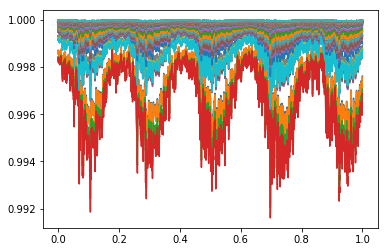

In [19]:
hidden_w = 10
input_w = 15  
output_w = 1

w_limit =  0.025 # step size for w
tau_limit = 0.2 # step size for eta

topology = [input_w, hidden_w, output_w]

random.seed(0)
numSamples = 1000  # need to decide yourself
use_langevin_gradients  = True
l_prob = 0.5
learn_rate = 0.01
timer = time.time()

mcmc = MCMC( use_langevin_gradients , l_prob,  learn_rate, numSamples, traindata, testdata, topology)  # declare class

[pos_w, pos_tau, fx_train, fx_test, x_train, x_test, rmse_train, rmse_test, accept_ratio] = mcmc.sampler(w_limit, tau_limit)

print ('sucessfully sampled')



In [ ]:
burnin = 0.6 * numSamples  # use post burn in samples

timer2 = time.time()
timetotal = (timer2 - timer) /60
print ((timetotal), 'min taken')

pos_w = pos_w[int(burnin):, ]
pos_tau = pos_tau[int(burnin):, ]

fx_mu = fx_test.mean(axis=0)
fx_high = np.percentile(fx_test, 95, axis=0)
fx_low = np.percentile(fx_test, 5, axis=0)

fx_mu_tr = fx_train.mean(axis=0)
fx_high_tr = np.percentile(fx_train, 95, axis=0)
fx_low_tr = np.percentile(fx_train, 5, axis=0)

pos_w_mean = pos_w.mean(axis=0)
#np.savetxt(outpos_w, pos_w_mean, fmt='%1.5f')


Dates:  90
Preds:  90


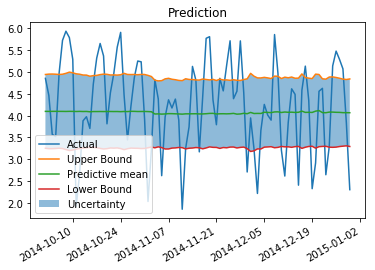

In [111]:
import datetime as dt
import matplotlib.dates as mdates

mydates = test_df['Date'].tolist()
dateset = [dt.datetime.strptime(d, "%Y-%m-%d").date() for d in mydates ]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d") )

upper_bound = y_mean + 1.0 * y_sigma
lower_bound = y_mean - 1.0 * y_sigma

print( "Dates: ", len(dateset) )
print( "Preds: ", len(y_mean) )

plt.plot(dateset, y_test, label='Actual')
plt.plot(dateset, upper_bound, label='Upper Bound')
plt.plot(dateset, y_mean, label='Predictive mean')
plt.plot(dateset, lower_bound, label='Lower Bound')

plt.fill_between(dateset, upper_bound, lower_bound, 
                 alpha=0.5, label='Uncertainty')

plt.gcf().autofmt_xdate()
plt.title('Prediction')
plt.legend();
